In [850]:
import pandas as pd
import numpy as np
import collections
from collections import OrderedDict
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm
import time
import metis
import pickle
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import random
import torch
import json
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from scipy.stats import norm
# torch.cuda.set_device(0)

In [2]:
torch.cuda.is_available()

True

In [3]:
pd.options.display.max_rows = 500
pd.set_option('display.max_columns', None)

In [4]:
# slurm_Cleaned = pd.read_csv("/home/abose//HPC Analytics GCN/slurmCleaned.csv")
# slurm_userSurvey = pd.read_csv("/home/abose//HPC Analytics GCN/slurmUserSurvey.csv")
slurm_user_ladap_merged = pd.read_csv("/home/abose/HPC Analytics GCN/2020_21.csv", low_memory=False)

In [26]:
slurm_user_ladap_merged.shape

(6934624, 112)

In [1368]:
# dict(slurm_user_ladap_merged.head(1))
features = ['JobID', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'role', 'GID', 'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'State', 'department']
slurm_Cleaned_Demo = slurm_user_ladap_merged[features].head(100000).copy()
slurm_Cleaned_Demo.head(12)

,JobID,TimelimitRaw,ReqMem,NCPUS,NNodes,AveVMSize,AveRSS,MaxVMSize,MaxRSS,AssocID,ReqCPUS,NodeList,UID,role,GID,q5,q6,q7,AvePages,CPUTimeRAW,State,department
0,8435065,34560.0,1Gc,32,1.0,NaN,NaN,NaN,NaN,625,32,dwarf36,2649.0,Faculty,2649.0,3.0,2.0,2.0,NaN,64116096,FAILED,Chemistry
1,8435065.batch,NaN,1Gc,32,1.0,173020K,8106244K,173020K,8106244K,625,32,dwarf36,NaN,NaN,NaN,NaN,NaN,NaN,131,64116096,FAILED,NaN
2,8435065.extern,NaN,1Gc,32,1.0,107952K,0,107952K,0,625,32,dwarf36,NaN,NaN,NaN,NaN,NaN,NaN,0,64116096,COMPLETED,NaN
3,8389362,34560.0,1Gc,32,1.0,NaN,NaN,NaN,NaN,625,32,dwarf50,2649.0,Faculty,2649.0,3.0,2.0,2.0,NaN,66355360,TIMEOUT,Chemistry
4,8389362.batch,NaN,1Gc,32,1.0,173032K,7099776K,173032K,7099776K,625,32,dwarf50,NaN,NaN,NaN,NaN,NaN,NaN,0,66355424,CANCELLED,NaN
5,8389362.extern,NaN,1Gc,32,1.0,107952K,0,107952K,0,625,32,dwarf50,NaN,NaN,NaN,NaN,NaN,NaN,0,66355360,COMPLETED,NaN
6,8519238,34560.0,1Gc,32,1.0,NaN,NaN,NaN,NaN,625,32,dwarf37,2649.0,Faculty,2649.0,3.0,2.0,2.0,NaN,29975232,FAILED,Chemistry
7,8519238.batch,NaN,1Gc,32,1.0,173112K,5715592K,173112K,5715592K,625,32,dwarf37,NaN,NaN,NaN,NaN,NaN,NaN,152,29975232,FAILED,NaN
8,8519238.extern,NaN,1Gc,32,1.0,107952K,0,107952K,0,625,32,dwarf37,NaN,NaN,NaN,NaN,NaN,NaN,0,29975232,COMPLETED,NaN
9,8532439,14400.0,150Gn,8,1.0,NaN,NaN,NaN,NaN,651,8,hero45,2754.0,UndergraduateStudent,2754.0,4.0,4.0,3.0,NaN,6912184,TIMEOUT,VeterinaryDiagnosticLaboratory


In [1369]:
slurm_Cleaned_Demo['State'] = slurm_Cleaned_Demo['State'].apply(lambda x: 1 if x == "COMPLETED" else 0)
df = pd.DataFrame({'a':list(slurm_Cleaned_Demo['State'])})
df.groupby('a').size()

a
0    14363
1    85637
dtype: int64

In [1370]:
slurm_Cleaned_Demo.drop(slurm_Cleaned_Demo[slurm_Cleaned_Demo['State'] == 0].index, inplace = True)  ##### Changed for Regression #####

In [1371]:
# slurm_Cleaned_Demo.to_csv('/home/abose/HPC Analytics GCN/slurm_Cleaned_Demo.csv', sep=',')

In [1372]:
slurm_Cleaned_Demo['MaxVMSize'] = slurm_Cleaned_Demo.MaxVMSize.str.extract('(\d+)')
slurm_Cleaned_Demo['MaxRSS'] = slurm_Cleaned_Demo.MaxRSS.str.extract('(\d+)')
slurm_Cleaned_Demo['AveVMSize'] = slurm_Cleaned_Demo.AveVMSize.str.extract('(\d+)')
slurm_Cleaned_Demo['AveRSS'] = slurm_Cleaned_Demo.AveRSS.str.extract('(\d+)')
slurm_Cleaned_Demo['AvePages'] = slurm_Cleaned_Demo.AveRSS.str.extract('(\d+)')
slurm_Cleaned_Demo['NewJobID'] = slurm_Cleaned_Demo['JobID'].apply(lambda x: str(x).split(".")[0])

In [1373]:
slurm_Cleaned_Demo['NewJobID'] = slurm_Cleaned_Demo['JobID'].apply(lambda x: str(x).split(".")[0])
slurm_Cleaned_Demo[['MaxVMSize', 'MaxRSS', 'AveVMSize', 'AveRSS', 'AssocID', 'ReqCPUS', 'AvePages']] = slurm_Cleaned_Demo[['MaxVMSize', 'MaxRSS', 'AveVMSize', 'AveRSS', 'AssocID', 'ReqCPUS', 'AvePages']].astype(float)

## JobID Input Processing ##

In [1374]:
def name_join(list_names, concat='-'):
    return concat.join(list_names)

In [1375]:
group_df = slurm_Cleaned_Demo.groupby('NewJobID')
group_df = group_df.agg({'JobID':name_join, 'TimelimitRaw':'first', 'ReqMem':'first', 'NCPUS':'first', 'NNodes':'first', 'AveVMSize': 'max', 'AveRSS':'max', 'MaxVMSize': 'max', 'MaxRSS': 'max', 'AssocID': 'max', 'ReqCPUS':'max', 'NodeList':'first', 'UID':'first', 'role':'first' ,'GID':'first', 'q5':'max', 'q6':'max', 'q7':'max', 'AvePages':'max', 'CPUTimeRAW':'first', 'State':'first', 'department':'first'})
s = group_df['JobID'].str.split('-').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'JobID'
del group_df['JobID']
group_df = group_df.join(s)
group_df = group_df.reset_index()
group_df.drop_duplicates(subset = ['NewJobID'], keep = 'first', inplace = True)
slurm_Cleaned_Demo = group_df.copy()

In [1376]:
### I SHOULD CHECK THE LIST CAREFULLY TO INCLUDE OR EXCLUDE SOME OF THE FEATURES

# X_listFeatures = ['failed', 'State', 'JobIDRaw', 'Account','AssocID', 'AllocCPUS', 'CPUTimeRAW', 'NCPUS', 'NNodes']
# X_listFeatures_1 = ['JobID', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'role', 'GID', 'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'State', 'department']
# X_listFeatures_1 = ['JobID', 'CPUTimeRAW', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'role', 'GID', 'q5', 'q6', 'q7']
# demoDF = slurm_Cleaned_Demo[X_listFeatures_1].dropna()
# demoDF.to_csv('/home/abose/HPC Analytics GCN/demoDF.csv', sep=',')

## ReqMem Numeric Parsing ##

In [1377]:
def memoryScaleConverter(Job):
    if 'Gc' in Job['ReqMem'] or 'Gn'in Job['ReqMem']:
        if 'Gc' in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Gc|(\d+)Gn").findall(Job['ReqMem'])[0])))
            return req_Mem*Job['NCPUS']
        if 'Gn'in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Gc|(\d+)Gn").findall(Job['ReqMem'])[0])))
            return req_Mem*Job['NNodes']
    if 'Mc' in Job['ReqMem'] or 'Mn'in Job['ReqMem']:
        if 'Mc' in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Mn|(\d+)Mc").findall(Job['ReqMem'])[0])))/1024
            return req_Mem*Job['NCPUS']
        if 'Mn' in Job['ReqMem']:
            req_Mem = float("".join(list(re.compile(r"(\d+)Mn|(\d+)Mc").findall(Job['ReqMem'])[0])))/1024
            return req_Mem*Job['NNodes']

In [1378]:
slurm_Cleaned_Demo['ReqMem'] = slurm_Cleaned_Demo.apply(lambda row: memoryScaleConverter(row), axis=1)

In [1379]:
slurm_Cleaned_Demo.dropna(subset=features,inplace=True)

In [1380]:
slurm_Cleaned_Demo['JobID'] = slurm_Cleaned_Demo['NewJobID'].copy()
del slurm_Cleaned_Demo['NewJobID']

In [1381]:
##### Changed for Regression #####
average = slurm_Cleaned_Demo.groupby('UID', as_index=False)['CPUTimeRAW', 'MaxVMSize', 'TimelimitRaw', 'ReqMem', 'MaxRSS'].mean()
average.columns = ['UID','aCPUTimeRAW','aMaxVMSize','aTimelimitRaw','aReqMem','aMaxRSS']
slurm_Cleaned_Demo = pd.merge(slurm_Cleaned_Demo, average, on=['UID'])
# del slurm_Cleaned_Demo['MaxRSS'] #### Include Either This 'MaxRSS' ####
del slurm_Cleaned_Demo['CPUTimeRAW'] #### Include Either This 'CPUTimeRAW' ####
slurm_Cleaned_Demo.columns
##### Changed for Regression #####

<ipython-input-1381-dfa2c44603b8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average = slurm_Cleaned_Demo.groupby('UID', as_index=False)['CPUTimeRAW', 'MaxVMSize', 'TimelimitRaw', 'ReqMem', 'MaxRSS'].mean()


Index(['TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS',
       'MaxVMSize', 'MaxRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'role',
       'GID', 'q5', 'q6', 'q7', 'AvePages', 'State', 'department', 'JobID',
       'aCPUTimeRAW', 'aMaxVMSize', 'aTimelimitRaw', 'aReqMem', 'aMaxRSS'],
      dtype='object')

In [1382]:
slurm_Cleaned_Demo = pd.get_dummies(slurm_Cleaned_Demo, columns=['department', 'role'])

In [1383]:
print("shape-> ", slurm_Cleaned_Demo.shape)
slurm_Cleaned_Demo

shape->  (22829, 43)


,TimelimitRaw,ReqMem,NCPUS,NNodes,AveVMSize,AveRSS,MaxVMSize,MaxRSS,AssocID,ReqCPUS,NodeList,UID,GID,q5,q6,q7,AvePages,State,JobID,aCPUTimeRAW,aMaxVMSize,aTimelimitRaw,aReqMem,aMaxRSS,department_Agronomy,department_AnatomyandPhysiology,department_Biology,department_ChemicalEngineering,department_Chemistry,department_CivilEngineering,department_ComputerScience,department_InstituteforEnvironmentalResearch,department_MathematicsandStatistics,department_Mechanical&NuclearEngineering,department_Physics,department_PlantPathology,department_VeterinaryDiagnosticLaboratory,role_Faculty,role_GraduateStudent,role_PostDoctoralResearcher,role_ResearchAssociate,role_Staff,role_UndergraduateStudent
0,10080.0,100.0,100,8.0,447735515.0,4.902704e+09,438772.0,10970696.0,2080.0,100.0,"elf[33-34,41-42,44,46,49,51]",3363.0,3363.0,2.0,3.0,1.0,4.902704e+09,1,8853689,4.123228e+07,438045.333333,11520.0,100.0,1.148973e+07,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,10080.0,100.0,100,13.0,446293674.0,9.046128e+06,437196.0,9598928.0,2080.0,100.0,"elf[06-08,10,12-14,17,26,29,40,44],hero22",3363.0,3363.0,2.0,3.0,1.0,9.046128e+06,1,8863178,4.123228e+07,438045.333333,11520.0,100.0,1.148973e+07,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,10080.0,100.0,100,13.0,441298602.0,5.897932e+06,431084.0,7463672.0,2080.0,100.0,"hero[18-19,22-27,29,31-33,53]",3363.0,3363.0,2.0,3.0,1.0,5.897932e+06,1,8863180,4.123228e+07,438045.333333,11520.0,100.0,1.148973e+07,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,10080.0,100.0,100,7.0,436630.0,1.007994e+07,438992.0,12299816.0,2080.0,100.0,"elf[26,33-34,41-42,44,46]",3363.0,3363.0,2.0,3.0,1.0,1.007994e+07,1,8863181,4.123228e+07,438045.333333,11520.0,100.0,1.148973e+07,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,14400.0,100.0,100,16.0,445267148.0,4.098618e+09,440736.0,12173984.0,2080.0,100.0,"elf[06-07,10,12,24,33,51,53],hero[17,20-21,24,...",3363.0,3363.0,2.0,3.0,1.0,4.098618e+09,1,8926397,4.123228e+07,438045.333333,11520.0,100.0,1.148973e+07,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22824,37440.0,20.0,20,1.0,173176.0,5.552184e+06,173176.0,5552184.0,250.0,20.0,mole036,2547.0,2548.0,4.0,3.0,1.0,5.552184e+06,1,8941283,9.464128e+06,173172.000000,34320.0,20.0,5.547957e+06,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22825,37440.0,20.0,20,1.0,173176.0,5.440292e+06,173176.0,5440292.0,250.0,20.0,mole037,2547.0,2548.0,4.0,3.0,1.0,5.440292e+06,1,8941286,9.464128e+06,173172.000000,34320.0,20.0,5.547957e+06,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22826,37440.0,20.0,20,1.0,173176.0,5.702324e+06,173176.0,5702324.0,250.0,20.0,mole040,2547.0,2548.0,4.0,3.0,1.0,5.702324e+06,1,8941452,9.464128e+06,173172.000000,34320.0,20.0,5.547957e+06,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22827,60.0,8.0,8,1.0,173120.0,5.519200e+04,173120.0,55192.0,477.0,8.0,wizard22,2315.0,2316.0,5.0,4.0,2.0,5.519200e+04,1,8938949,2.720000e+02,173120.000000,60.0,8.0,5.519200e+04,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [1384]:
# ['JobID', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'AssocID', 'ReqCPUS', 'NodeList', 'UID', 'role', 'GID', 'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'State', 'department']
# list_neumeric = ['aCPUTimeRAW','aMaxVMSize','aTimelimitRaw','aReqMem', 'aMaxRSS', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'ReqCPUS', 'q5', 'q6', 'q7', 'AvePages', 'department_Agronomy', 'department_ChemicalEngineering', 'department_Chemistry', 'department_ComputerScience', 'department_InstituteforEnvironmentalResearch', 'department_Mechanical&NuclearEngineering', 'department_Physics', 'department_PlantPathology', 'department_VeterinaryDiagnosticLaboratory', 'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher', 'role_ResearchAssociate', 'role_UndergraduateStudent'] ##### FOR Classification #####
### , 'role_UndergraduateStudent', 'department_InstituteforEnvironmentalResearch', 'MaxRSS', 'CPUTimeRAW'
list_neumeric = ['aCPUTimeRAW','aMaxVMSize','aTimelimitRaw','aReqMem', 'aMaxRSS', 'TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'ReqCPUS', 'q5', 'q6', 'q7', 'AvePages', 'department_Agronomy', 'department_ChemicalEngineering', 'department_Chemistry', 'department_ComputerScience', 'department_Mechanical&NuclearEngineering', 'department_Physics', 'department_PlantPathology', 'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher', 'role_ResearchAssociate']  ##### Changed for Regression #####

In [1385]:
# list_neumeric = ['TimelimitRaw', 'ReqMem', 'NCPUS', 'NNodes', 'AveVMSize', 'AveRSS', 'MaxVMSize', 'MaxRSS', 'ReqCPUS', 'q5', 'q6', 'q7', 'AvePages', 'CPUTimeRAW', 'department_AgriculturalEconomics', 'department_Agronomy', 'department_AnatomyandPhysiology', 'department_BiochemistryandMolecularBiophysics', 'department_BiologicalSciences', 'department_Biology', 'department_BiomedicalandHealthInformatics', 'department_ChemicalEngineering', 'department_Chemistry', 'department_CivilEngineering', 'department_ComputerScience', 'department_Economics', 'department_Entomology', 'department_Geography', 'department_InstituteforEnvironmentalResearch', 'department_MathematicsandStatistics', 'department_Mechanical&NuclearEngineering', 'department_Physics', 'department_PlantPathology', 'department_PsychologicalSciences', 'department_Statistics', 'department_VeterinaryDiagnosticLaboratory', 'role_Faculty', 'role_GraduateStudent', 'role_PostDoctoralResearcher', 'role_ResearchAssociate', 'role_Staff', 'role_UndergraduateStudent']

In [1386]:
normalized_slurm_Cleaned_Demo=(slurm_Cleaned_Demo[list_neumeric]-slurm_Cleaned_Demo[list_neumeric].min())/(slurm_Cleaned_Demo[list_neumeric].max()-slurm_Cleaned_Demo[list_neumeric].min())

In [1387]:
normalized_slurm_Cleaned_Demo.shape

(22829, 28)

## Adding JobID Column to the Normalized Neumeric Dataset ##

In [1388]:
normalized_slurm_Cleaned_Demo['JobID'] = slurm_Cleaned_Demo['JobID'].copy()

In [1389]:
first_column = normalized_slurm_Cleaned_Demo.pop('JobID')
normalized_slurm_Cleaned_Demo.insert(0, 'JobID', first_column)

In [1390]:
normalized_slurm_Cleaned_Demo.columns = range(normalized_slurm_Cleaned_Demo.shape[1])

In [1391]:
normalized_slurm_Cleaned_dictionary = normalized_slurm_Cleaned_Demo.set_index(0).agg(list, axis=1).to_dict()

In [1392]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
save_obj(normalized_slurm_Cleaned_dictionary, 'slurm_job_feature_dictionary')

In [1393]:
normalized_slurm_Cleaned_Demo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,8853689,1.000000,0.246736,0.284650,0.165275,0.048804,0.248882,0.066044,1.000000,0.466667,0.308225,1.000000,0.247279,1.000000,0.25,0.50,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,8863178,1.000000,0.246736,0.284650,0.165275,0.048804,0.248882,0.066044,1.000000,0.800000,0.307232,0.001845,0.246101,1.000000,0.25,0.50,0.000000,0.001845,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,8863180,1.000000,0.246736,0.284650,0.165275,0.048804,0.248882,0.066044,1.000000,0.800000,0.303792,0.001203,0.241533,1.000000,0.25,0.50,0.000000,0.001203,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,8863181,1.000000,0.246736,0.284650,0.165275,0.048804,0.248882,0.066044,1.000000,0.400000,0.000226,0.002056,0.247444,1.000000,0.25,0.50,0.000000,0.002056,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,8926397,1.000000,0.246736,0.284650,0.165275,0.048804,0.356185,0.066044,1.000000,1.000000,0.306525,0.835991,0.248747,1.000000,0.25,0.50,0.000000,0.835991,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22824,8941283,0.229532,0.048750,0.850969,0.031720,0.023565,0.928465,0.012675,0.191919,0.000000,0.000045,0.001132,0.048753,0.191919,0.75,0.50,0.000000,0.001132,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22825,8941286,0.229532,0.048750,0.850969,0.031720,0.023565,0.928465,0.012675,0.191919,0.000000,0.000045,0.001110,0.048753,0.191919,0.75,0.50,0.000000,0.001110,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22826,8941452,0.229532,0.048750,0.850969,0.031720,0.023565,0.928465,0.012675,0.191919,0.000000,0.000045,0.001163,0.048753,0.191919,0.75,0.50,0.000000,0.001163,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22827,8938949,0.000006,0.048711,0.000000,0.011686,0.000234,0.000000,0.004670,0.070707,0.000000,0.000045,0.000011,0.048711,0.070707,1.00,0.75,0.333333,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


   ## ---------------- ## ---------------- ## ----------------------- ## ------------------- ## ---------------------##

array([[<AxesSubplot:title={'center':'MaxVMSize'}>]], dtype=object)

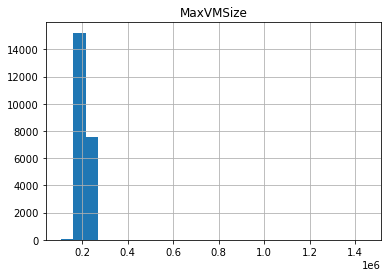

In [1394]:
pd.DataFrame(slurm_Cleaned_Demo['MaxVMSize']).hist(bins=25)

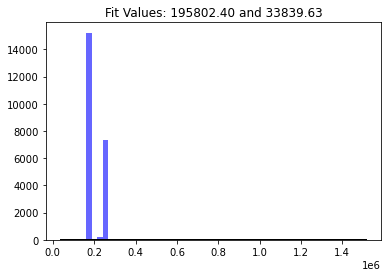

In [1395]:
plt.hist(slurm_Cleaned_Demo['MaxVMSize'], bins=50, alpha=0.6, color='b')
mu, std = norm.fit(slurm_Cleaned_Demo['MaxVMSize'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()
plt.show()

### I will not consider the following features ###
#### ReqNodes, TRESUsageOutMaxTask, ExitCode, billing, MaxDiskReadTask, MaxDiskWriteTask, MaxDiskWrite, MaxDiskRead, NTasks, 

## Data preparation and transformation for model features and targets ##

In [1396]:
# pdDf = pd.DataFrame({'TotalCPU':['227-18:12:13', '10:15.16', '19:14:17']})
# pdDf['TotalCPU'].apply(lambda x: timedelta(days = float(x.split('-')[0]), hours = float(x.split('-')[1].split(':')[0]), minutes = float(x.split('-')[1].split(':')[1]), seconds = float(x.split('-')[1].split(':')[2])).total_seconds() if re.search(r"(\d+)-", x) else (datetime.strptime('00:' + x.split(':')[0] + ':' + x.split(':')[1].split('.')[0], "%H:%M:%S") - datetime(1900, 1, 1)).total_seconds() if re.search(r"(\w+[:]\w+)(\w+[.]\w+)", x) else (datetime.strptime(x,'%H:%M:%S')- datetime(1900,1,1)).total_seconds())
# slurm_Cleaned_Demo = slurm_Cleaned.head(10000).copy()
# slurm_Cleaned_Demo['TotalCPU'] = slurm_Cleaned_Demo['TotalCPU'].apply(lambda x: timedelta(days = float(x.split('-')[0]), hours = float(x.split('-')[1].split(':')[0]), minutes = float(x.split('-')[1].split(':')[1]), seconds = float(x.split('-')[1].split(':')[2])).total_seconds() if re.search(r"(\d+)-", x) else (datetime.strptime('00:' + x.split(':')[0] + ':' + x.split(':')[1].split('.')[0], "%H:%M:%S") - datetime(1900, 1, 1)).total_seconds() if re.search(r"(\w+[:]\w+)(\w+[.]\w+)", x) else (datetime.strptime(x,'%H:%M:%S')- datetime(1900,1,1)).total_seconds())
# slurm_Cleaned_Demo['TotalCPU'] = slurm_Cleaned_Demo['TotalCPU'].multiply(slurm_Cleaned_Demo['NCPUS'], axis="index")

In [1397]:
slurm_Cleaned_Demo.to_csv("/home/abose/HPC Analytics GCN/slurm_Cleaned_Demo.csv", sep=',', index=False)

### Make unique Neumeric entry for "Account" and "AssocID" fields

In [1398]:
# print(demoDF[demoDF['failed'] == 0].index.values, type(demoDF[demoDF['failed'] == 0].index.values), type(demoDF[demoDF['failed'] == 0].index), len(demoDF[demoDF['failed'] == 0].index), len(demoDF[demoDF['failed'] == 1].index))
# for i in demoDF.index.values:
#     print(i, demoDF.loc[i, 'JobIDRaw'])

### The following code block process the Target node lebels

In [1399]:
def load_Save_Target_Data(args):
    """Loads dataset and graph if exists, else create and process them from raw data
    Returns --->
    selected: indexes of selected labelled nodes for training
    test_idxs: indexes of not-selected nodes for inference/testing
    labels_selected: labels of selected labelled nodes for training
    labels_not_selected: labels of not-selected labelled nodes for inference/testing
    """
    
    demoDF=pd.read_csv('/home/abose/HPC Analytics GCN/slurm_Cleaned_Demo.csv', index_col=False)
    ### stratified test samples
    test_idxs = []
    for status in demoDF['State'].unique():
        dum = demoDF[demoDF['State'] == status].index.values
        print("status-> ", status, " dum-> ", len(dum))
        test_idxs.extend(list(np.random.choice(dum, size=round(args['test_ratio']*len(dum)), replace=False)))

    
    # select only certain labelled nodes for semi-supervised GCN
    print("test_idxs-> ", test_idxs)
    selected = []
    jobID_selected = list()
    jobID_not_selected = list()
    for i in demoDF.index.values:
        if i not in test_idxs:
            selected.append(i)
            jobID_selected.append(demoDF.loc[i, 'JobID'])
        if i in test_idxs:
            jobID_not_selected.append(demoDF.loc[i, 'JobID'])
    
#     labels_all = [(l['JobID'], l['State']) for idx, l in demoDF.iterrows()] ##### FOR Classification #####
#     labels_selected = [l['State'] for idx, l in demoDF.iterrows() if idx in selected] ##### FOR Classification #####
#     labels_not_selected = [l['State'] for idx, l in demoDF.iterrows() if idx not in selected] ##### FOR Classification #####
    
      ##### Changed for Regression #####
#     labels_all = [(l['JobID'], l['CPUTimeRAW']) for idx, l in demoDF.iterrows()]
#     labels_selected = [l['CPUTimeRAW'] for idx, l in demoDF.iterrows() if idx in selected]
#     labels_not_selected = [l['CPUTimeRAW'] for idx, l in demoDF.iterrows() if idx not in selected]
    
    labels_all = [(l['JobID'], l['MaxRSS']) for idx, l in demoDF.iterrows()]
    labels_selected = [l['MaxRSS'] for idx, l in demoDF.iterrows() if idx in selected]
    labels_not_selected = [l['MaxRSS'] for idx, l in demoDF.iterrows() if idx not in selected]
      ##### Changed for Regression #####
    
    train_TargetDict = dict()
    test_TargetDict = dict()
    print("selected-> ", len(selected), " labels_selected-> ", len(labels_selected), " test_idxs-> ", len(test_idxs), "labels_not_selected-> ", len(labels_not_selected))
    train_TargetDict['Node_ID']=jobID_selected
    train_TargetDict['Label']=labels_selected
    test_TargetDict['Node_ID']= jobID_not_selected
    test_TargetDict['Label']=labels_not_selected
    targetDf=pd.DataFrame(labels_all, columns=['Node_ID', 'Label'])
    train_TargetDf=pd.DataFrame(train_TargetDict)
    test_TargetDf=pd.DataFrame(test_TargetDict)
    targetDf.to_csv('/home/abose//HPC Analytics GCN/targetDf.csv', sep=',', index=False)
    train_TargetDf.to_csv('/home/abose//HPC Analytics GCN/train_TargetDf.csv', sep=',', index=False)
    test_TargetDf.to_csv('/home/abose//HPC Analytics GCN/test_TargetDf.csv', sep=',', index=False)
    print("Split into %d train and %d test lebels." % (len(labels_selected), len(labels_not_selected)))
    return selected, labels_selected, labels_not_selected, test_idxs

## Model's Data preparation ends here

## Data Preparation for Graph Generation ##

#### The following code block defines a function that is used for bining purpose to assign values in different keys of above mentioned two dictionaries ####

In [1400]:
def featureSet_Group_Generator(Job, Flag, resource_dictionay):
    if Flag=="CPU":
        cpuList_Container_dictionary = resource_dictionay
#         if Job['ReqCPUS']>0 and Job['ReqCPUS']<= 4:
#             cpuList_Container_dictionary["mono1"].append(Job['JobID'])
#         elif Job['ReqCPUS']>4 and Job['ReqCPUS']<= 9:
#             cpuList_Container_dictionary["mono2"].append(Job['JobID'])
#         elif Job['ReqCPUS']>9 and Job['ReqCPUS']<= 19:
#             cpuList_Container_dictionary["decim1"].append(Job['JobID'])
#         elif Job['ReqCPUS']>19 and Job['ReqCPUS']<= 32:
#             cpuList_Container_dictionary["decim2"].append(Job['JobID'])
#         elif Job['ReqCPUS']>32 and Job['ReqCPUS']<= 64:
#             cpuList_Container_dictionary["decim3"].append(Job['JobID'])
#         elif Job['ReqCPUS']>64 and Job['ReqCPUS']<= 128:
#             cpuList_Container_dictionary["centu1"].append(Job['JobID'])
#         elif Job['ReqCPUS']>128 and Job['ReqCPUS']<= 256:
#             cpuList_Container_dictionary["centu2"].append(Job['JobID'])
#         if Job['ReqCPUS']>256 and Job['ReqCPUS']<= 512:
#             cpuList_Container_dictionary["centu"].append(Job['JobID'])
        if Job['ReqCPUS']>500:
            cpuList_Container_dictionary["centu4"].append(Job['JobID'])
        return cpuList_Container_dictionary
    if Flag=="Memory":
        memList_Container_dictionary = resource_dictionay
#         if Job['ReqMem']>1 and Job['ReqMem'] <= 3:
#             memList_Container_dictionary["squaric"].append(Job['JobID'])
#         elif Job['ReqMem'] > 3 and Job['ReqMem'] <= 7:
#             memList_Container_dictionary["cubic"].append(Job['JobID'])
#         elif Job['ReqMem'] > 7 and Job['ReqMem'] <= 15:
#             memList_Container_dictionary["quartic"].append(Job['JobID'])
#         elif Job['ReqMem'] > 15 and Job['ReqMem'] <= 31:
#             memList_Container_dictionary["pentaic"].append(Job['JobID'])
#         elif Job['ReqMem'] > 31 and Job['ReqMem'] <= 63:
#             memList_Container_dictionary["hexaic"].append(Job['JobID'])
#         elif Job['ReqMem'] > 63 and Job['ReqMem'] <= 127:
#             memList_Container_dictionary["heptaic"].append(Job['JobID'])
#         elif Job['ReqMem'] > 127 and Job['ReqMem'] <= 256:
#             memList_Container_dictionary["octaic"].append(Job['JobID'])
#         if Job['ReqMem'] > 256 and Job['ReqMem'] <= 512:
#             memList_Container_dictionary["nonaic"].append(Job['JobID'])
        if Job['ReqMem'] > 500:
            memList_Container_dictionary["decaic"].append(Job['JobID'])
        return memList_Container_dictionary
    
    if Flag=="q5":
        q5List_Container_dictionary = resource_dictionay
#         if Job['q5']== 1:
#             q5List_Container_dictionary['beginner'].append(Job['JobID'])
#         elif Job['q5']== 3 or Job['q5'] == 4:
#             q5List_Container_dictionary['experienced'].append(Job['JobID'])
        if Job['q5']== 5:
            q5List_Container_dictionary['expert'].append(Job['JobID'])
        return q5List_Container_dictionary
    
    if Flag=="q6":
        q6List_Container_dictionary = resource_dictionay
#         if Job['q6']== 1:
#             q6List_Container_dictionary['beginner'].append(Job['JobID'])
        if Job['q6'] == 5:
            q6List_Container_dictionary['expert'].append(Job['JobID'])
        return q6List_Container_dictionary
    
    if Flag=="q7":
        q7List_Container_dictionary = resource_dictionay
#         if Job['q7']== 1:
#             q7List_Container_dictionary['weakly_trained'].append(Job['JobID'])
        if Job['q7'] == 4:
            q7List_Container_dictionary['trained'].append(Job['JobID'])
        return q7List_Container_dictionary

#### The following function is used to calculate the (node, node) tuple from the dictionaries created by above

In [1401]:
# def implicit_Relation_Maker(List_Container_dictionary):
#     element_element=list()
#     for key, itemList in List_Container_dictionary.items():
#         for idx, element in enumerate(itemList):
#             for x in range(idx+1, len(itemList)-1):
#                 element_element.append((str(element), str(itemList[x])))
#     return element_element

In [1402]:
def implicit_Relation_Maker(List_Container_dictionary, dummy_node):
    element_element=list()
    for key, itemList in List_Container_dictionary.items():
        for idx, element in enumerate(itemList):
            element_element.append((str(element), dummy_node))
    return element_element

In [1403]:
def graph_data_builder():
    #### The following code block defines a dictionary with different keys for bining purpose to constract a heterogenous graph ####
    cpuList_Container_dictionary = dict()
#     cpuList_Container_dictionary["mono1"]=list()
#     cpuList_Container_dictionary["mono2"]=list()
#     cpuList_Container_dictionary["decim1"]=list()
#     cpuList_Container_dictionary["decim2"]=list()
#     cpuList_Container_dictionary["decim3"]=list()
#     cpuList_Container_dictionary["centu1"]=list()
#     cpuList_Container_dictionary["centu2"]=list()
#     cpuList_Container_dictionary["centu"]=list()
    cpuList_Container_dictionary["centu4"]=list()

    memList_Container_dictionary = dict()
#     memList_Container_dictionary["squaric"]=list()
#     memList_Container_dictionary["cubic"]=list()
#     memList_Container_dictionary["quartic"]=list()
#     memList_Container_dictionary["pentaic"]=list()
#     memList_Container_dictionary["hexaic"]=list()
#     memList_Container_dictionary["heptaic"]=list()
#     memList_Container_dictionary["octaic"]=list()
#     memList_Container_dictionary["nonaic"]=list()
    memList_Container_dictionary["decaic"]=list()
    
    q5List_Container_dictionary = dict()
#     q5List_Container_dictionary['beginner'] = list()
#     q5List_Container_dictionary['experienced'] = list()
    q5List_Container_dictionary['expert'] = list()
    
    q6List_Container_dictionary = dict()
#     q6List_Container_dictionary['beginner'] = list()
    q6List_Container_dictionary['expert'] = list()
    
    q7List_Container_dictionary = dict()
#     q7List_Container_dictionary['weakly_trained'] = list()
    q7List_Container_dictionary['trained'] = list()
    

    #### The following code block iterates the datasets to create tuples of (node, node, weight) for both implicit and
    #### explicit relations between different types of nodes.
#     AssocID_jobID=list()
#     AssocID_JobName=list()
#     JobName_jobID = list()
#     NodeList_jobID = list()
    UID_jobID = list()
#     GID_UID = list()
#     UID_department = list()
#     GID_department = list()
#     GID_AssocID = list()
    for index, row in slurm_Cleaned_Demo.iterrows():
        cpuList_Container_dictionary = featureSet_Group_Generator(row, "CPU", cpuList_Container_dictionary)
        memList_Container_dictionary = featureSet_Group_Generator(row, "Memory", memList_Container_dictionary)
        
        q5List_Container_dictionary = featureSet_Group_Generator(row, "q5", q5List_Container_dictionary)
        q6List_Container_dictionary = featureSet_Group_Generator(row, "q6", q6List_Container_dictionary)
        q7List_Container_dictionary = featureSet_Group_Generator(row, "q7", q7List_Container_dictionary)
        
#         JobName_jobID.append((str(row['JobName']), str(row['JobID'])))
#         AssocID_jobID.append((str(row['AssocID']), str(row['JobID'])))
#         AssocID_JobName.append((str(row['AssocID']), str(row['JobName'])))
#         NodeList_jobID.append((row['NodeList'], row['JobID']))
        UID_jobID.append((str(row['UID']), str(row['JobID'])))
#         GID_UID.append((str(row['GID']), str(row['UID'])))
#         UID_department.append((str(row['UID']), str(row['department'])))
#         GID_department.append((str(row['GID']), str(row['department'])))
#         GID_AssocID.append((str(row['GID']), str(row['AssocID'])))

    #### The following code block merges several dataframes and generates concateneted 
    #### Nodes are 'AssocID', 'Account', 'JobID', 'JobName', 'NodeList, GID, UID, department'
#     JobName_jobID_DF= pd.DataFrame(JobName_jobID, columns = ['Src', 'Des'])
#     AssocID_jobID_DF = pd.DataFrame(AssocID_jobID, columns =['Src', 'Des'])
#     AssocID_JobName_DF = pd.DataFrame(AssocID_JobName, columns =['Src', 'Des'])
#     NodeList_jobID_DF= pd.DataFrame(NodeList_jobID, columns = ['Src', 'Des'])
    UID_jobID_DF= pd.DataFrame(UID_jobID, columns = ['Src', 'Des'])
#     GID_UID_DF= pd.DataFrame(GID_UID, columns = ['Src', 'Des'])
#     UID_department_DF= pd.DataFrame(UID_department, columns = ['Src', 'Des'])
#     GID_department_DF= pd.DataFrame(GID_department, columns = ['Src', 'Des'])
#     GID_AssocID_DF= pd.DataFrame(GID_AssocID, columns = ['Src', 'Des'])
    cpu_JobID_JobID_DF= pd.DataFrame(implicit_Relation_Maker(cpuList_Container_dictionary, 'V'), columns = ['Src', 'Des'])
    mem_JobID_JobID_DF= pd.DataFrame(implicit_Relation_Maker(memList_Container_dictionary, 'W'), columns = ['Src', 'Des'])
    
    q5_JobID_JobID_DF= pd.DataFrame(implicit_Relation_Maker(q5List_Container_dictionary, 'X'), columns = ['Src', 'Des'])
    q6_JobID_JobID_DF= pd.DataFrame(implicit_Relation_Maker(q6List_Container_dictionary, 'Y'), columns = ['Src', 'Des'])
    q7_JobID_JobID_DF= pd.DataFrame(implicit_Relation_Maker(q7List_Container_dictionary, 'Z'), columns = ['Src', 'Des'])
    
#     graph_DF = pd.concat([AssocID_jobID_DF, UID_jobID_DF, GID_UID_DF, UID_department_DF, GID_department_DF, GID_AssocID_DF, cpu_JobID_JobID_DF, mem_JobID_JobID_DF, q5_JobID_JobID_DF, q6_JobID_JobID_DF, q7_JobID_JobID_DF])
#     graph_DF = pd.concat([AssocID_jobID_DF, UID_jobID_DF, GID_UID_DF, UID_department_DF, GID_department_DF, GID_AssocID_DF, cpu_JobID_JobID_DF, mem_JobID_JobID_DF, q5_JobID_JobID_DF, q6_JobID_JobID_DF, q7_JobID_JobID_DF])
    graph_DF = pd.concat([UID_jobID_DF, cpu_JobID_JobID_DF, mem_JobID_JobID_DF, q5_JobID_JobID_DF, q6_JobID_JobID_DF, q7_JobID_JobID_DF])
    print("graph_DF DataType-> ", graph_DF.dtypes)
    graph_DF.to_csv("/home/abose/HPC Analytics GCN/graph_DF.csv", sep=',', index=False)

## Data Preparation for Graph Ends ##

## Graph Generation Process Starts from here

#### Mapping heterogenous nodes to numeric values ####

In [1404]:
# nxNode_to_Index_Mapping = {node:ind for ind, node in enumerate(list(nx_graph.nodes()))}
# index_to_nxNode_Mapping = {ind:node for ind, node in enumerate(list(nx_graph.nodes()))}

In [1405]:
# count_graph=nx.read_edgelist('/home/abose/HPC Analytics GCN/graph_DF.csv', delimiter=',') ##### FOR Classification #####
# print("Job Node-> ", len(set(slurm_Cleaned_Demo['JobID'])), " UID Node-> ", len(set(slurm_Cleaned_Demo['UID'])), " GID Node-> ", len(set(slurm_Cleaned_Demo['GID'])), " No of Edges-> ", len(count_graph.edges()), " Average Degree-> ", sum(dict(count_graph.degree()).values())/len(count_graph.nodes())) ##### FOR Classification #####
# print((len(set(slurm_Cleaned_Demo['JobID']))+len(set(slurm_Cleaned_Demo['UID']))+len(set(slurm_Cleaned_Demo['GID'])))*0.8,(len(set(slurm_Cleaned_Demo['JobID']))+len(set(slurm_Cleaned_Demo['UID']))+len(set(slurm_Cleaned_Demo['GID'])))*0.2) ##### FOR Classification #####

In [1406]:
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [1407]:
def make_mapped_Embedding_for_Nodes(nx_graph, index_node_mapping):
    normalized_slurm_Cleaned_dictionary = load_obj('slurm_job_feature_dictionary')
    node_Emedding_Dict = OrderedDict()
    node_List= list(nx_graph.nodes())
    
    for idx, node_element in enumerate(node_List):
        if index_node_mapping[node_element] in normalized_slurm_Cleaned_dictionary:
            node_Emedding_Dict[node_element] = normalized_slurm_Cleaned_dictionary[index_node_mapping[node_element]]
        else:
            node_Emedding_Dict[node_element]=np.random.rand(normalized_slurm_Cleaned_Demo.shape[1]-1)
    
    embedding_DataFrame=pd.DataFrame(node_Emedding_Dict)
    embedding_DataFrame.to_csv('/home/abose/HPC Analytics GCN/embedding_Dataframe.csv', sep=',')
    print("embedding_DataFrame.shape-> ", embedding_DataFrame.shape)
    return embedding_DataFrame

In [1408]:
# def make_Embedding_for_Nodes(nx_graph):
#     node_Emedding_Dict = OrderedDict()
#     id_matrix = np.eye(len(nx_graph.nodes()))
#     node_List= list(nx_graph.nodes())
#     for idx, node_element in enumerate(node_List):
#         node_Emedding_Dict[node_element] = id_matrix[idx]
#     embedding_DataFrame=pd.DataFrame(node_Emedding_Dict)
#     embedding_DataFrame.to_csv('/home/abose/HPC Analytics GCN/embedding_Dataframe.csv', sep=',')
#     print("embedding_DataFrame.shape-> ", embedding_DataFrame.shape)
#     return embedding_DataFrame

In [1409]:
# def node_embedding_mapper(normalized_slurm_Cleaned_dictionary, word_Value_Dict):
#     complete_slurm_feature_dictionary=pd.DataFrame()
#     for item, value in word_Value_Dict.items():
#         if item in normalized_slurm_Cleaned_dictionary:
#             complete_slurm_feature_dictionary[value]=normalized_slurm_Cleaned_dictionary[item]
#         else:
#             print("word not in new embed df-> ", item)
#             complete_slurm_feature_dictionary[value]=np.random.rand(28)
#     return complete_slurm_feature_dictionary

#### The following code block convert string nodes label to neumeric node labels

In [1410]:
def neumeric_node_mapper():
    src_des_edges=pd.read_csv('/home/abose/HPC Analytics GCN/graph_DF.csv')
    totalNodeList=list(set(src_des_edges['Src']).union(set(src_des_edges['Des'])))
    node_neumeric_mapping = {str(node): i for i, node in enumerate(totalNodeList)}
    index_node_mapping = {i: str(node) for i, node in enumerate(totalNodeList)}
    neumeric_node_node_Dict=dict()
    src_List=list()
    des_List=list()
    score_List=list()
    for indx, row in src_des_edges.iterrows():
        row=dict(row)
        if str(row['Src']) in node_neumeric_mapping and str(row['Des']) in node_neumeric_mapping:
            src_List.append(node_neumeric_mapping[str(row['Src'])])
            des_List.append(node_neumeric_mapping[str(row['Des'])])
    neumeric_node_node_Dict['Src']=src_List
    neumeric_node_node_Dict['Des']=des_List
    src_des_edges=pd.DataFrame(neumeric_node_node_Dict)
    node_neumeric_mapping_DF= pd.DataFrame(list(node_neumeric_mapping.items()),columns = ['Node_ID','Assigned_ID'])
    node_neumeric_mapping_DF.to_csv('/home/abose/HPC Analytics GCN/node_neumeric_mapping.csv', sep=',', index=False)
    src_des_edges.to_csv('/home/abose/HPC Analytics GCN/src_des_edges.csv', header=False, sep=',', index=False)
    return node_neumeric_mapping, index_node_mapping

### Mapping the Target dataframe index to numeric identifier that has been indexed by the jobID earlier ###

In [1411]:
def target_mapper(target, nodeMap, data_chunk):
    newTargetNode=list()
    newTargetLabel=list()
    newTargetDict=dict()
    for index, item in target.iterrows():
        if str(item["Node_ID"]) in nodeMap:
#             print("-> ", item["Node_ID"])
            newTargetNode.append(nodeMap[str(item["Node_ID"])])
            newTargetLabel.append(item["Label"])
    newTargetDict["Node_ID"] = newTargetNode
    newTargetDict["Label"] = newTargetLabel
    newTarget = pd.DataFrame(newTargetDict)
    if data_chunk == 0:
        newTarget.to_csv("/home/abose//HPC Analytics GCN/new_Target.csv", sep=',', index=False)
    if data_chunk == 1:
        newTarget.to_csv("/home/abose//HPC Analytics GCN/new_Train_Target.csv", sep=',', index=False)
    if data_chunk == 2:
        newTarget.to_csv("/home/abose//HPC Analytics GCN/new_Test_Target.csv", sep=',', index=False)
    return newTarget

#### The following line finally creates a graph from the saved CSV file from the concatenated dataframe

In [1412]:
def graph_generation():
    graph_data_builder()
    node_neumeric_mapping, index_node_mapping = neumeric_node_mapper()
    nx_graph=nx.read_edgelist('/home/abose/HPC Analytics GCN/src_des_edges.csv', delimiter=',', nodetype=int)
#     print(nx.info(nx_graph))
#     nx.draw(nx_graph)
#     plt.show()
    return nx_graph, node_neumeric_mapping, index_node_mapping

## Graph Generation Ends ##

## Graph Convolutional Part ##

In [1413]:
class StackedGCN(torch.nn.Module):
    """
    Multi-layer GCN model.
    """
    def __init__(self, args, input_channels, output_channels):
        """
        :param args: Arguments object.
        :input_channels: Number of features.
        :output_channels: Number of target features. 
        """
        super(StackedGCN, self).__init__()
        self.args = args
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.setup_layers()
        
    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.args['layers'] = [self.input_channels] + self.args['layers'] + [self.output_channels]
        for i, _ in enumerate(self.args['layers'][:-1]):
            self.layers.append(GCNConv(self.args['layers'][i],self.args['layers'][i+1]))
        self.layers = ListModule(*self.layers)

#     def forward(self, edges, features, weights):
    def forward(self, edges, features):
        """
        Making a forward pass.
        :param edges: Edge list LongTensor.
        :param features: Feature matrix input FLoatTensor.
        :return predictions: Prediction matrix output FLoatTensor.
        """
        for i, _ in enumerate(self.args['layers'][:-2]):
#             features = torch.nn.functional.relu(self.layers[i](features, edges, weights))
            features = torch.nn.functional.relu(self.layers[i](features, edges))
            if i>1:
                features = torch.nn.functional.dropout(features, p = self.args['dropout'], training = self.training)
#         features = self.layers[i+1](features, edges, weights)
        features = self.layers[i+1](features, edges)
#         predictions = torch.nn.functional.log_softmax(features, dim=1) ##### FOR Classification ##### ???
#         predictions = torch.nn.functional.linear(features) ##### Changed for Regression #####
        predictions = features ##### Changed for Regression #####
#         predictions = torch.nn.functional.sigmoid(features)
        print("StackedGCN Forward pred size-> ", predictions.size)
        return predictions

class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)

In [1414]:
class ClusteringMachine(object):
    """
    Clustering the graph, feature set and target.
    """
    def __init__(self, args, graph, features, target, train_Target, test_Target):
        """
        :param args: Arguments object with parameters.
        :param graph: Networkx Graph.
        :param features: Feature matrix (ndarray).
        :param target: Target vector (ndarray).
        """
        self.args = args
        self.graph = graph
        self.features = features
#         print("cls Machine features-> ", features)
        self.target = target
        self.train_Target = train_Target
        self.test_Target = test_Target
        self._set_sizes()

    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.feature_count = self.features.shape[0]
#         self.class_count = np.max(self.target['Label'])+1 ##### FOR Classification #####
        self.class_count = 1 ##### Changed for Regression #####

    def decompose(self):
        """
        Decomposing the graph, partitioning the features and target, creating Torch arrays.
        """
        if self.args['clustering_method'] == "metis":
            print("\nMetis graph clustering started.\n")
            self.metis_clustering()
        else:
            print("\nRandom graph clustering started.\n")
            self.random_clustering()
        self.general_data_partitioning()
        self.transfer_edges_and_nodes()

    def random_clustering(self):
        """
        Random clustering the nodes.
        """
        self.clusters = [cluster for cluster in range(self.args['cluster_no'])]
        self.cluster_membership = {node: random.choice(self.clusters) for node in self.graph.nodes()}

    def metis_clustering(self):
        """
        Clustering the graph with Metis. For details see:
        """
        (st, parts) = metis.part_graph(self.graph, self.args['cluster_no'])
        self.clusters = list(set(parts))
#         print("parts------->>>>> ", len(parts), " self.graph.nodes------->>>>> ", len(self.graph.nodes()), " +++ ", self.graph.nodes())
#         for node, membership in enumerate(parts):
#             print("node-> ", int(node)+1, " membership-> ", membership)
        graph_Node_List = list(self.graph.nodes())
#         ********* My GCN WORK SHOULD DEFINITELY NOTICE IT ********** 
        self.cluster_membership = {graph_Node_List[node]: membership for node, membership in enumerate(parts)}
        with open('cluster_membership.json', 'w') as fp:
            json.dump(self.cluster_membership, fp)

    def general_data_partitioning(self):
        """
        Creating data partitions and train-test splits.
        """
        self.sg_nodes = {}
        self.sg_edges = {}
#         self.sg_edge_weights = {}
        self.sg_train_nodes = {}
        self.sg_test_nodes = {}
        self.sg_features = {}
        # self.sg_targets = {}
        self.sg_train_targets ={}
        self.sg_test_targets ={}
        self.sg_train_target_nodes = {}
        self.sg_test_target_nodes = {}
        # print("self.clusters-> ", self.clusters, " self.cluster_membership-> ", self.cluster_membership)
        for cluster in self.clusters:
            subgraph = self.graph.subgraph([node for node in sorted(self.graph.nodes()) if self.cluster_membership[int(node)] == cluster])
            self.sg_nodes[cluster] = [node for node in sorted(subgraph.nodes())]
            # print(" Check 1st sub nodes-> ", self.sg_nodes[cluster], " Check 1st sub edges-> ",  subgraph.edges())
            mapper = {node: i for i, node in enumerate(sorted(self.sg_nodes[cluster]))} 
            edge_data = [[mapper[edge[0]], mapper[edge[1]]] for edge in subgraph.edges()] +  [[mapper[edge[1]], mapper[edge[0]]] for edge in subgraph.edges()]
            self.sg_edges[cluster] = [[elements[0], elements[1]] for i, elements in enumerate(edge_data)]
#             self.sg_edge_weights[cluster] = [elements[2] for i, elements in enumerate(edge_data)]
            self.sg_train_nodes[cluster], self.sg_test_nodes[cluster] = train_test_split(list(mapper.values()), test_size = self.args['test_ratio'])
            self.sg_test_nodes[cluster] = sorted(self.sg_test_nodes[cluster])
            self.sg_train_nodes[cluster] = sorted(self.sg_train_nodes[cluster])
            self.sg_features[cluster] = self.features[self.sg_nodes[cluster]].values.T

            # The following lists will be used as temporary container for keeping mapped Train and Test sample node ids in the current subgraph by checking nodes' existance in the Target dictionary
            trainTarget=list()
            testTarget=list()

            copy_temp_target = self.target.copy()
            # Checking whether target nodes are in the mapper dictionary or not for this Subgraph or Cluster of nodes // Discard Null Values that are not matched
            copy_temp_target = copy_temp_target[copy_temp_target['Node_ID'].isin(mapper.keys())]

            # Replace target dataframe Node_ID column by mapping with mapper dictionary
            copy_temp_target = copy_temp_target.replace({'Node_ID': mapper})

            # Making a dictionary from the target dataframe where Node_ID is the key and Label is the value
            target_dict=copy_temp_target.set_index('Node_ID')['Label'].to_dict()

            # Getting a list of Label values by mapping keys from subgraph train+test nodes cluster with target dictionary 
            self.sg_train_targets[cluster] = [target_dict.get(key) for key in self.sg_train_nodes[cluster]]
            self.sg_test_targets[cluster] = [target_dict.get(key) for key in self.sg_test_nodes[cluster]]
  
            # Removing None from the Target labels list
            self.sg_train_targets[cluster] = [i for i in self.sg_train_targets[cluster] if i is not None]
            self.sg_test_targets[cluster] = [i for i in self.sg_test_targets[cluster] if i is not None]
            
            # Converting from List of numeric values to an one dimentional array
            self.sg_train_targets[cluster] = np.array(self.sg_train_targets[cluster])
            self.sg_test_targets[cluster] = np.array(self.sg_test_targets[cluster])

            # Transposing the array of both Train and Test Matrix
            self.sg_train_targets[cluster] = self.sg_train_targets[cluster].reshape(-1,1)
            self.sg_test_targets[cluster] = self.sg_test_targets[cluster].reshape(-1,1)

            # Checking whether a node in Train or Test Cluster is in the target dictionary or not 
            if len(self.sg_train_targets[cluster])>0:
                for nodeId in self.sg_train_nodes[cluster]:
                    if nodeId in target_dict.keys():
                        trainTarget.append(nodeId)
            if len(self.sg_test_targets[cluster])>0:
                for nodeId in self.sg_test_nodes[cluster]:
                    if nodeId in target_dict.keys():
                        testTarget.append(nodeId)

            self.sg_train_target_nodes[cluster] = trainTarget
            self.sg_test_target_nodes[cluster] = testTarget
            # print("Node id diff -> ", set(self.sg_train_target_nodes[cluster])-set(target_dict.keys())," Target key diff -> ", set(target_dict.keys())-set(self.sg_train_target_nodes[cluster]))
            print("Target Train Array Shape-> ", self.sg_train_targets[cluster].shape, " Target Test Array Shape-> ", self.sg_test_targets[cluster].shape)

    def transfer_edges_and_nodes(self):
        """
        Transfering the data to PyTorch format.
        """
        for cluster in self.clusters:
#             if not self.sg_edges[cluster] and self.sg_edge_weights[cluster]:
            if not self.sg_edges[cluster]:
                continue
            self.sg_nodes[cluster] = torch.LongTensor(self.sg_nodes[cluster])
            self.sg_edges[cluster] = torch.LongTensor(self.sg_edges[cluster]).t()
#             self.sg_edge_weights[cluster] = torch.FloatTensor(self.sg_edge_weights[cluster]).t()
            self.sg_train_target_nodes[cluster] = torch.LongTensor(self.sg_train_target_nodes[cluster])
            self.sg_test_target_nodes[cluster] = torch.LongTensor(self.sg_test_target_nodes[cluster])
            self.sg_train_targets[cluster] = torch.LongTensor(self.sg_train_targets[cluster])
            self.sg_test_targets[cluster] = torch.LongTensor(self.sg_test_targets[cluster])
            self.sg_features[cluster] = torch.FloatTensor(self.sg_features[cluster])

In [1415]:
class ClusterGCNTrainer(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, args, clustering_machine):
        """
        :param ags: Arguments object.
        :param clustering_machine:
        """  
        self.args = args
        self.clustering_machine = clustering_machine
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
        print("feature_count_1-> ", self.clustering_machine.feature_count," class_count_1-> ", self.clustering_machine.class_count)
        self.model = StackedGCN(self.args, self.clustering_machine.feature_count, self.clustering_machine.class_count)
        self.model = self.model.to(self.device)

    def do_forward_pass(self, cluster):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        print("Know the Type-> ", type(self.clustering_machine.sg_edges[cluster]), len(self.clustering_machine.sg_edges[cluster]))
        edges = self.clustering_machine.sg_edges[cluster].to(self.device)
#         weights = self.clustering_machine.sg_edge_weights[cluster].to(self.device)
        macro_nodes = self.clustering_machine.sg_nodes[cluster].to(self.device)
        train_nodes = self.clustering_machine.sg_train_target_nodes[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        target = torch.squeeze(self.clustering_machine.sg_train_targets[cluster].to(self.device), 1)
        # target = self.clustering_machine.sg_train_targets[cluster].to(self.device).squeeze()
#         predictions = self.model(edges, features, weights)
        predictions = self.model(edges, features)
        print("*** Check Carefully ***", "Input Train Nodes-> ", predictions[train_nodes].size(), " Target Train Nodes-> ", target.size())
#         print("predictions[train_nodes]-> ", len(predictions[train_nodes]), " Target Train Nodes-> ", len(target))
#         average_loss = torch.nn.functional.nll_loss(predictions[train_nodes], target) ##### For Classification #####
        average_loss = torch.nn.functional.mse_loss(predictions[train_nodes], target.to(torch.float32)) ##### Changed for Regression #####
        print("Avg MSE Loss-> ", average_loss) ##### Changed for Regression #####
#         average_loss = torch.nn.functional.binary_cross_entropy(predictions[train_nodes], target)
#         print("Eikhane Dekh -> ",  type(predictions[train_nodes]), predictions[train_nodes], " *** ", type(target), target)
#         check = torch.argmax(predictions[train_nodes,:], dim=1)
#         clust_acc_score= accuracy_score(torch.argmax(predictions[train_nodes,:], dim=1).cpu().detach().numpy(), target.cpu().detach().numpy()) ##### For Accuracy #####
        node_count = train_nodes.shape[0]
#         return clust_acc_score, average_loss, node_count ##### For Accuracy #####
        return average_loss, node_count

    def update_average_loss(self, batch_average_loss, node_count):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item()*node_count
        self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss/self.node_count_seen
        return average_loss

    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        edges = self.clustering_machine.sg_edges[cluster].to(self.device)
#         weights = self.clustering_machine.sg_edge_weights[cluster].to(self.device)
        macro_nodes = self.clustering_machine.sg_nodes[cluster].to(self.device)
        test_nodes = self.clustering_machine.sg_test_target_nodes[cluster].to(self.device)
        features = self.clustering_machine.sg_features[cluster].to(self.device)
        target = torch.squeeze(self.clustering_machine.sg_test_targets[cluster].to(self.device), 1)
#         prediction = self.model(edges, features, weights)
        prediction = self.model(edges, features)
        prediction = prediction[test_nodes,:]
        return prediction, target

    def train(self):
        """
        Training a model.
        """
        print("Training started.\n")
        epochs = trange(self.args['epochs'], desc = "Train Loss")
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr_rate'])
        self.model.train()
        loss_values = list()
        accuracy_values = list() ##### For Accuracy #####
        for epoch in epochs:
            random.shuffle(self.clustering_machine.clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in self.clustering_machine.clusters:
                
                self.optimizer.zero_grad()
#                 batch_acc_score, batch_average_loss, node_count = self.do_forward_pass(cluster) ##### For Accuracy #####
                batch_average_loss, node_count = self.do_forward_pass(cluster)
                batch_average_loss.backward()
                self.optimizer.step()
                average_loss = self.update_average_loss(batch_average_loss, node_count)
#                 batch_acc_score = self.update_average_loss(batch_acc_score, node_count) ##### For Accuracy #####
            loss_values.append(average_loss)
#             accuracy_values.append(batch_acc_score) ##### For Accuracy #####
                # avg_acc_score = self.update_average_loss(batch_acc_score, node_count)
            epochs.set_description("Train Loss: %g" % round(average_loss,4))
#             print("Accuracy-> ", batch_acc_score*100, "%") ##### For Accuracy #####
#             epochs.set_description("Train Accuracy: ", avg_acc_score*100, "%") ##### For Accuracy Alternative #####
            
            
        plt.figure(figsize=(10,5))
        plt.title("Training Loss", fontsize=18)
#         plt.plot(accuracy_values, 'b', label='Train Accuracy')
        plt.plot(loss_values, 'g', label="Train Loss")
        plt.xlabel("iterations", fontsize=18)
        plt.ylabel("Loss", fontsize=18)
        plt.legend(fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.show()
        
    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_prediction(cluster)
#             self.predictions.append(prediction.cpu().detach().numpy()) ##### For Classification #####
            self.predictions.append(np.squeeze(prediction).cpu().detach().numpy()) ##### Changed for Regression #####
            self.targets.append(target.cpu().detach().numpy())
        self.targets = np.concatenate(self.targets)
#         self.predictions = np.concatenate(self.predictions).argmax(1) ##### For Classification #####
        self.predictions = np.concatenate(self.predictions) ##### Changed for Regression #####
        print(len(self.targets)," Type", type(self.targets), " ******** "," Type ", type(self.predictions), len(self.predictions))
        print("R Squred-> ", r2_score(self.targets, self.predictions))
        reg_Corr = pd.DataFrame({'Actual':self.targets, 'Predicted':self.predictions}) ##### Changed for Regression #####
        reg_Corr.to_csv("/home/abose/HPC Analytics GCN/corr.csv", sep=',') ##### Changed for Regression #####
        print("Regression-> ", reg_Corr.corr(method='pearson')) ##### Changed for Regression #####
#         test_acc_score= accuracy_score(self.targets, self.predictions) ##### For Classification #####
#         ####F1_Score = f1_score(self.targets, self.predictions, average="micro")
#         ####F1_Score = f1_score(self.targets, self.predictions, pos_label=1, average = "binary")
#         F1_Score = f1_score(self.targets, self.predictions, labels = [0]) ##### For Classification #####
#         precision = precision_score(self.targets, self.predictions, labels = [0]) ##### For Classification #####
#         recall = recall_score(self.targets, self.predictions, labels = [0]) ##### For Classification #####
#         print("\nTest Acc score: {:.4f}".format(test_acc_score), "  \nPrecision score: {:.4f}".format(precision), "  \nRecall score: {:.4f}".format(recall), "  \nF-1 score: {:.4f}".format(F1_Score)) ##### For Classification #####

## GCN part ends here ##

## Controller part ##

In [1416]:
def parameter_processor():
    args=dict()
    args['clustering_method']= "No"
    args['epochs']= 50 ##### Changed for Regression #####
#     args['epochs']= 400 ##### For Classification #####
    args['seed']= 42
    args['dropout']= 0.5
#     args['lr_rate']= 0.01 ##### For Classification #####
    args['lr_rate']= 0.2 ##### Changed for Regression #####
    args['test_ratio']= 0.20
    args['cluster_no']= 3
#     args['layers']=[64, 64, 64] ##### For Classification #####
    args['layers']=[64] ##### Changed for Regression #####
    
    return args

In [1417]:
def read_HPC_data(args):
    nx_graph, node_neumeric_mapping, index_node_mapping = graph_generation()
    load_Save_Target_Data(args)
    
    target = pd.read_csv('/home/abose/HPC Analytics GCN/targetDf.csv')
    # nodeMap = pd.read_csv('/home/abose/HPC Analytics GCN/node_neumeric_mapping.csv')
    target = target_mapper(target, node_neumeric_mapping, 0)
    
    train_Target = pd.read_csv('/home/abose/HPC Analytics GCN/train_TargetDf.csv')
    # nodeMap = pd.read_csv('/home/abose/HPC Analytics GCN/node_neumeric_mapping.csv')
    train_Target = target_mapper(train_Target, node_neumeric_mapping, 1)
    
    test_Target = pd.read_csv('/home/abose/HPC Analytics GCN/test_TargetDf.csv')
    test_Target = target_mapper(test_Target, node_neumeric_mapping, 2)
    
    features = make_mapped_Embedding_for_Nodes(nx_graph, index_node_mapping)
    return nx_graph, target, train_Target, test_Target, features

graph_DF DataType->  Src    object
Des    object
dtype: object
status->  1  dum->  22829
test_idxs->  [9624, 8493, 17398, 20955, 13173, 1845, 3434, 9032, 11524, 18054, 6793, 17778, 4738, 15660, 5856, 1846, 15366, 20087, 8982, 16456, 12680, 9289, 9853, 9318, 12206, 18696, 19449, 5449, 20570, 178, 21460, 17733, 3565, 4202, 16786, 8058, 7526, 21402, 19649, 22077, 11535, 18455, 5364, 13949, 6672, 6234, 767, 17576, 18424, 4098, 13626, 1889, 6295, 21842, 1662, 17502, 21934, 5484, 12784, 12636, 3248, 20124, 898, 14130, 205, 20746, 10370, 21193, 12527, 12744, 20721, 21964, 14037, 16289, 19200, 1761, 22828, 15019, 1792, 11890, 15544, 7219, 1281, 1340, 10429, 22121, 7086, 14169, 14861, 21767, 18023, 17021, 3860, 1894, 2529, 13061, 16773, 11145, 7402, 37, 10360, 7510, 915, 18630, 5456, 1503, 18580, 11579, 11288, 21818, 22734, 11576, 16874, 20074, 6068, 20865, 12178, 125, 5957, 1829, 1800, 14415, 1770, 21706, 11509, 7433, 17731, 16685, 20710, 20089, 2627, 1925, 10078, 3167, 2166, 18976, 2063, 1784

selected->  18263  labels_selected->  18263  test_idxs->  4566 labels_not_selected->  4566
Split into 18263 train and 4566 test lebels.
embedding_DataFrame.shape->  (28, 22867)
Number of Nodes-> 22867

Random graph clustering started.

Target Train Array Shape->  (6066, 1)  Target Test Array Shape->  (1515, 1)
Target Train Array Shape->  (6032, 1)  Target Test Array Shape->  (1509, 1)


Train Loss:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-1415-42505503192d>:43: UserWarning: Using a target size (torch.Size([6166])) that is different to the input size (torch.Size([6166, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  average_loss = torch.nn.functional.mse_loss(predictions[train_nodes], target.to(torch.float32)) ##### Changed for Regression #####
<ipython-input-1415-42505503192d>:43: UserWarning: Using a target size (torch.Size([6066])) that is different to the input size (torch.Size([6066, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  average_loss = torch.nn.functional.mse_loss(predictions[train_nodes], target.to(torch.float32)) ##### Changed for Regression #####
<ipython-input-1415-42505503192d>:43: UserWarning: Using a target size (torch.Size([6032])) that is different to the input size (torch.Size([6032, 1])). This will likely le

Target Train Array Shape->  (6166, 1)  Target Test Array Shape->  (1541, 1)
feature_count_1->  28  class_count_1->  1
Training started.

Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a369d180>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(3.0470e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a369d480>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9987e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a369d580>
*** Check Carefully *** Input Train Nodes->  torch.Size([6032, 1])  Target Train Nodes->  t

Train Loss: 5.84363e+13:  26%|██▌       | 13/50 [00:00<00:00, 38.93it/s]

Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4d40>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9977e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4d40>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(3.0457e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4280>
*** Check Carefully *** Input Train Nodes->  torch.Size([6032, 1])  Target Train Nodes->  torch.Size([6032])
Avg MSE Loss->  tensor(1.1576e+14, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 

Train Loss: 5.83591e+13:  42%|████▏     | 21/50 [00:00<00:00, 36.81it/s]

Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4580>
*** Check Carefully *** Input Train Nodes->  torch.Size([6032, 1])  Target Train Nodes->  torch.Size([6032])
Avg MSE Loss->  tensor(1.1572e+14, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4880>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(3.0404e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4800>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9927e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 

Train Loss: 5.82356e+13:  50%|█████     | 25/50 [00:00<00:00, 36.28it/s]

Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4a80>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(3.0313e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4180>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9846e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c48c0>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(3.0302e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 

Train Loss: 5.8068e+13:  66%|██████▌   | 33/50 [00:00<00:00, 35.42it/s] 

Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36d1640>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9725e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36d1980>
*** Check Carefully *** Input Train Nodes->  torch.Size([6032, 1])  Target Train Nodes->  torch.Size([6032])
Avg MSE Loss->  tensor(1.1550e+14, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36d1500>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(3.0152e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 

Train Loss: 5.78575e+13:  82%|████████▏ | 41/50 [00:01<00:00, 35.63it/s]

StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4680>
*** Check Carefully *** Input Train Nodes->  torch.Size([6032, 1])  Target Train Nodes->  torch.Size([6032])
Avg MSE Loss->  tensor(1.1534e+14, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a369d780>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(2.9964e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4880>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9538e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-i

Train Loss: 5.75757e+13: 100%|██████████| 50/50 [00:01<00:00, 36.13it/s]


Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4a00>
*** Check Carefully *** Input Train Nodes->  torch.Size([6066, 1])  Target Train Nodes->  torch.Size([6066])
Avg MSE Loss->  tensor(2.9339e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a369df00>
*** Check Carefully *** Input Train Nodes->  torch.Size([6032, 1])  Target Train Nodes->  torch.Size([6032])
Avg MSE Loss->  tensor(1.1512e+14, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 2
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36c4940>
*** Check Carefully *** Input Train Nodes->  torch.Size([6166, 1])  Target Train Nodes->  torch.Size([6166])
Avg MSE Loss->  tensor(2.9702e+13, device='cuda:0', grad_fn=<MseLossBackward>)
Know the Type->  <class 'torch.Tensor'> 

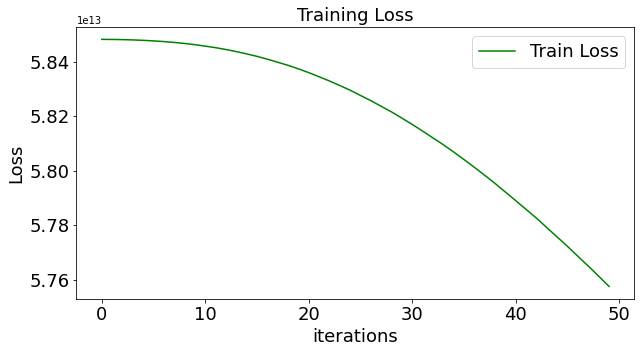

StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd7a36d18c0>
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd804d6a600>
StackedGCN Forward pred size->  <built-in method size of Tensor object at 0x7fd804d6ae40>
4565  Type <class 'numpy.ndarray'>  ********   Type  <class 'numpy.ndarray'> 4565
R Squred->  -0.16026211020793557
Regression->               Actual  Predicted
Actual     1.000000   0.140048
Predicted  0.140048   1.000000


In [1418]:
def main():
    """
    Parsing command line parameters, reading data, graph decomposition, fitting a ClusterGCN and scoring the model.
    """
    args = parameter_processor()
    nx_graph, target, train_Target, test_Target, features = read_HPC_data(args)
    print("Number of Nodes->", len(list(nx_graph.nodes())))
    clustering_machine = ClusteringMachine(args, nx_graph, features, target, train_Target, test_Target)
    clustering_machine.decompose()
    gcn_trainer = ClusterGCNTrainer(args, clustering_machine)
    gcn_trainer.train()
    gcn_trainer.test()

if __name__ == "__main__":
    main()

In [ ]:
# average = temp.groupby('owner', as_index=False)['cpu','maxvmem','reqTime','reqMem','mem'].mean()
# average.columns = ['owner','aCPU','aMaxvmem','aReqtime','aReqmem','aMem']
# t3 = pd.merge(temp, average, on=['owner'])
# t3.columns

In [ ]:
#[['owner', 'failed', 'project', 'cpu', 'maxvmem', 'reqTime', 'reqMem', 'people','mem']]
# 'CPUtimeraw' and 'MaxRSS' should be the predicted value, TimelimitRaw is not there
# cpu -> (AveCPU/TotalCPU/) CPUtimeraw, maxvmem -> MaxVMSize, reqTime-> TimelimitRaw, ReqMem-> ReqMem, mem -> MaxRSS (Maximum resident set size)

# average = temp.groupby('owner', as_index=False)['cpu','maxvmem','reqTime','ReqMem','mem'].mean()
# average.columns = ['owner','aCPU','aMaxvmem','aReqtime','aReqmem','aMem']
# t3 = pd.merge(temp, average, on=['owner'])
# t3.columns

# nx_G=nx.read_edgelist('/home/abose/HPC Analytics GCN/src_des_edges.csv', delimiter=',', nodetype=str)
# H = nx.convert_node_labels_to_integers(nx_G)

In [488]:
batch_size = 5
num_classes = 8
x = torch.rand(batch_size, num_classes)
y = torch.randint(num_classes, (batch_size,))

input1 = torch.randn(3, 15, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(input1), target)
# output
# output.backward()
# torch.nn.functional.binary_cross_entropy(input1, target)

<ipython-input-488-2caf5216d96f>:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(input1), target)


tensor(2.4814, grad_fn=<NllLossBackward>)

In [489]:
# df = pd.DataFrame([[60, 64, np.nan], ['60.ext', 67, 100], ['60.eng', 72, 0], [72, 75, np.nan], ['72.ext', 79, 101], ['72.eng', 82, 0], [82, 85, np.nan]], columns=['JobID', 'UID', 'MaxRSS'])
# .apply(lambda x: (" ".join(x["t"])).lower())
# slurm_Cleaned_Demo.groupby(slurm_Cleaned_Demo['NewJobID']).agg({'JobID': 'first', 'MaxVMSize': 'max', 'MaxRSS': 'max', 'AveVMSize': 'max', 'AveRSS':'max', 'AssocID': 'max', 'ReqCPUS':'max', 'UID':'max', 'GID':'max', 'q5':'max', 'q6':'max', 'q7':'max'}).reset_index()
# slurm_Cleaned_Demo.groupby(slurm_Cleaned_Demo['NewJobID']).agg({'JobID': 'first', 'UID': 'max', 'NTasks':'max'}).reset_index()
def name_join(list_names, concat='-'):
    return concat.join(list_names)
slurm_Cleaned_Demo['DataFrame Column'] = slurm_Cleaned_Demo['MaxVMSize'].astype(float)
group_df = slurm_Cleaned_Demo.groupby('NewJobID')
# group_df = group_df.agg({'NodeList':name_join, 'MaxVMSize': 'max', 'MaxRSS': 'max', 'AveVMSize': 'max', 'AveRSS':'max', 'AssocID': 'max', 'ReqCPUS':'max', 'UID':'max', 'role':'first','university':'first' ,'GID':'max', 'q5':'max', 'q6':'max', 'q7':'max'})
group_df = group_df.agg({'NodeList':name_join, 'MaxVMSize': 'max'})
s = group_df['NewJobID'].str.split('-').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'NewJobID'
del group_df['NewJobID']
group_df = group_df.join(s)
group_df.reset_index()

KeyError: 'NewJobID'

In [ ]:
from torch_scatter import scatter_mean
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
for data in loader:
    print(data, len(data.to_data_list()), data.y.unique(), data.to_data_list())

In [417]:
m = torch.nn.LogSoftmax(dim=1)
loss = torch.nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)
output.backward()

In [422]:
input

tensor([[ 0.7709, -1.0619,  0.4434,  1.3743, -0.3757],
        [-0.1636,  0.0159, -0.1985,  0.1198, -0.5375],
        [ 0.2817, -0.0839,  0.6825,  0.9339,  0.6968]], requires_grad=True)